# This is baseline notebook for 5th round modelling for P2:
1) done: Get Niall's data ready to be fit. both capacity and voltage at only EOL and BOL
2) done: (easy) three temperature, 10,25,40
3) done: include charge throughput in post-processing
4) done: upgrade: "Initial electrolyte excessive amount ratio" merge with dryout option
5) 50%: try again the electorlyte properties decrease at high c(Li+) 
6) to be added: add Niall's complictaed charaterization test
7) decide whether to save the last solution 
8) try not just the whole cycle range, try every cycle range 
9) fit the starting RPT capacity by changing initial SOC

In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
import openpyxl
import traceback
import multiprocessing

In [3]:
ChemistryChen=pb.parameter_sets.Chen2020               # OKane2022
Para_0=pb.ParameterValues(chemistry=ChemistryChen);
print(Para_0['Initial concentration in negative electrode [mol.m-3]'])
print(Para_0['Initial concentration in positive electrode [mol.m-3]'])
ChemistryOKane2022=pb.parameter_sets.OKane2022               # OKane2022
Para_1=pb.ParameterValues(chemistry=ChemistryOKane2022);
print(Para_1['Initial concentration in negative electrode [mol.m-3]'])
print(Para_1['Initial concentration in positive electrode [mol.m-3]'])

29866.0
17038.0
29866.0
17038.0


In [ ]:
# dig out from SolventConsumption branch: 
#       RioCode\Acer\R_4\Plot_parameter_value_for_paper.ipynb
#       see also slide desk_3 Page 35
# exponential extrapolation:
def electrolyte_diffusivity_Nyman_Rio(c_e, T):
    D_c_e = 6 * np.exp( -1 *(c_e/1000)) * np.exp(-5/298.15) * np.exp(-95/298.15*(c_e/1000)) * 1e-10 
    return D_c_e    
def electrolyte_conductivity_Nyman_Rio(c_e, T):
    sigma_e = 0.1 * 0.06248 * (1+298.15-0.05559) * (c_e/1e3) * (1 - 3.084 *np.sqrt(c_e/1e3) + 1.33 *(1+ 0.03633 *(np.exp(1000/298.15))*c_e/1e3)   ) / (1+(c_e/1e3)**4*( 0.00795 *np.exp(1000/298.15))) 
    return sigma_e

In [5]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 

from Fun_P2_Crack_simp import (
    GetScan,
    recursive_scan,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,)

In [6]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[8,],
   "Ageing cycles between RPT":[4,],
   "Update cycles for ageing":[4,],
   "Cycles within RPT":[2,],
   "Ageing temperature":[25,],
   "RPT temperature":[25,],
   "Particle mesh points":[30,],   # Simon uses 30
   #"Exponential mesh stretch":[1.0,],
   "Para_Set":[ "OKane2022",],
   "electrolyte":["lipf6_Nyman2008Rio"],
   "Model option":[
         {
            "calculate discharge energy":"true",
            "particle": "Fickian diffusion",          
            "SEI":"solvent-diffusion limited",   
            "SEI on cracks":"true",  
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",      
            "particle mechanics":("swelling and cracking", "swelling only"), 
            "loss of active material":"stress-driven", 
            "lithium plating":"partially reversible"      },
         ],

   # Solvent consumption sub-model
   "Initial electrolyte excessive amount ratio":[1.05,], # set to <1 for DryOut=Off 
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   #"Negative electrode diffusivity [m2.s-1]":[2e-13,], # default: a function, about 3.3e-14
   #"Positive electrode diffusivity [m2.s-1]":[1e-13,], # default: 4e-15
   "Initial concentration in negative electrode [mol.m-3]": [28920.0,29020.0,29520.0,29920.0,30520.0,],# default: 29866.0
   "Initial concentration in positive electrode [mol.m-3]": [18038.0,18538.0,18938.0,19038.0,19538.0,],# default: 17038.0
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[2.5e-23,],       # default: 2.5e-22
   'Bulk solvent concentration [mol.m-3]':[4541.0,],          # default: 4541.0
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[1e-12,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity [m2.s-1]':[2e-20,],
   'SEI kinetic rate constant [m.s-1]':[1e-19,], 
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-9,], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 2.7778e-9,], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 2.7778e-9,], # default: 2.7778e-07
   # make it simple for now,], but may want to have T dependency in the future
   #"Negative electrode cracking rate":[ 3.9e-20,],   # default: function, ~3.9e-20
   #"Positive electrode cracking rate":[ 3.9e-20,],   # default: function, ~3.9e-20
   "Negative electrode volume change":[ 0.0,],
   "Positive electrode volume change":[ 0.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})


# define experiments
V_max = 4.2;        
V_min = 2.5; 
exp_AGE_text = [(f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ]
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (f"Discharge at 0.1C until {V_min} V",  
        "Rest for 1 hours",  
        f"Charge at 0.1C until {V_max} V" ) ]
# step index for RPT
step_RPT_CD = 0;  step_RPT_RE =1;   step_RPT_CC = 2;  

exp_text_list = [exp_AGE_text, exp_RPT_text,];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_RPT_CD,step_RPT_RE , step_RPT_CC ];

#len(Para_dict_list)

In [10]:
temp_Int_ElelyExces_Ratio = 1.01
if temp_Int_ElelyExces_Ratio < 1:
    Int_ElelyExces_Ratio = 1.0;
    DryOut = "Off";
else:
    Int_ElelyExces_Ratio = temp_Int_ElelyExces_Ratio;
    DryOut = "On";
print(Int_ElelyExces_Ratio);
print(DryOut)

1.01
On


# Test - write in excel
type(str(model_options))
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2R3/'; 
Target  = 'Test_crack_xx/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'write_head.xlsx';

sheet_name_xlsx = 'Results';

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];


value3 = [
   ["Index", "Ratio_ex","cs_Neg_Init", "Diff_SEI", "R_SEI", 
   "Bulk_Sol_Con","D_Li_inSEI", "c_Li_inte_ref",
   "Diff_EC","k_SEI","LAMcr_prop","Crack_rate",
   "Couple_SEI_LiP","k_LiP","Temper_i","mesh_par",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error",str(model_options)],
   ]
write_excel_xlsx(BasicPath + Target+book_name_xlsx, sheet_name_xlsx, value3)


In [11]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Throughput capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

Successfully create a excel file
On
Finish the break-in cycle
Initial electrolyte amount is  5.636104110000001 mL
Succeed in 8 minutes, 32 seconds
This is the  1  scan
Off
Finish the break-in cycle
Succeed in 8 minutes, 25 seconds
This is the  2  scan


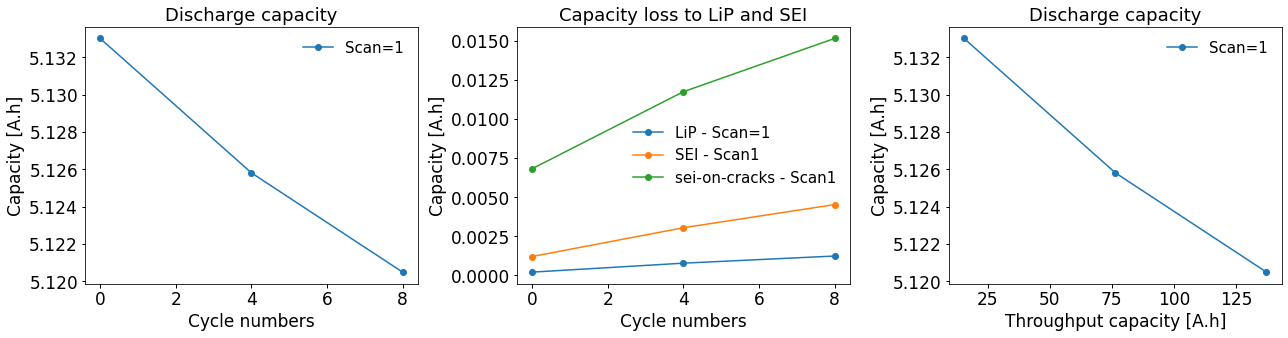

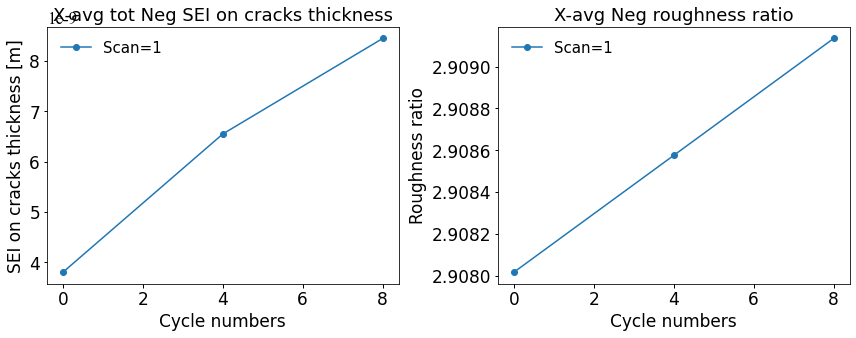

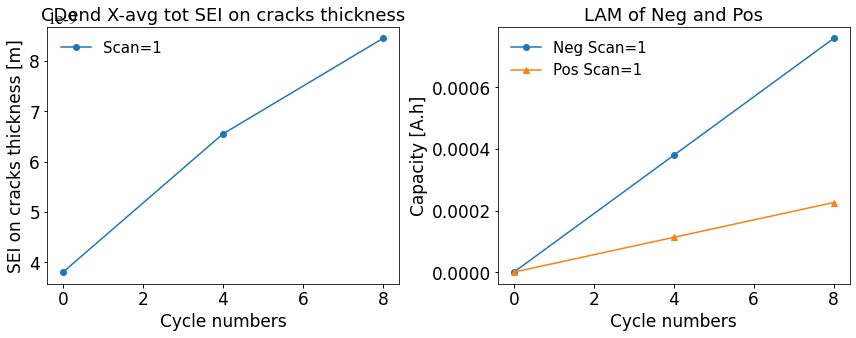

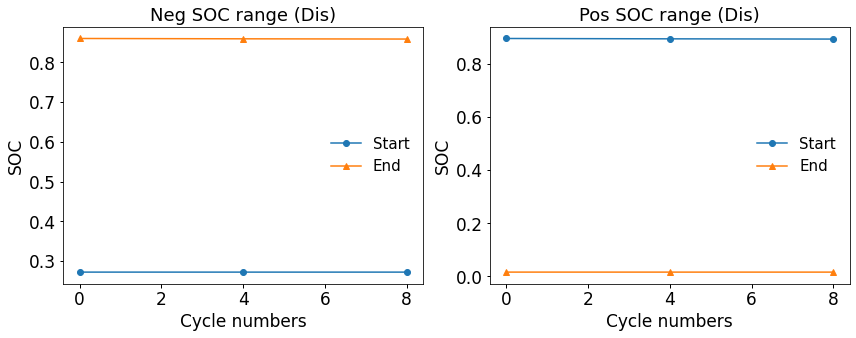

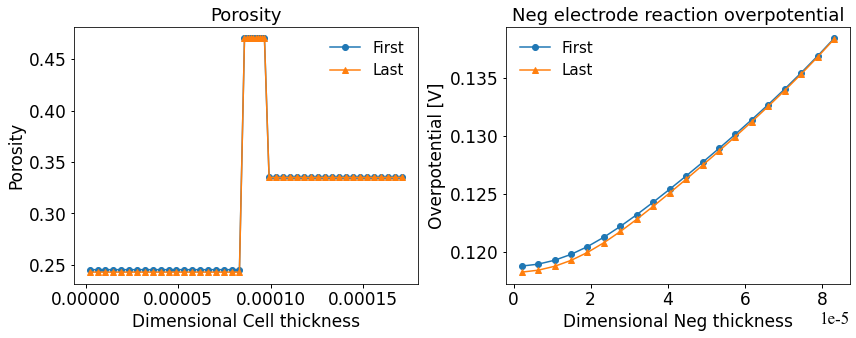

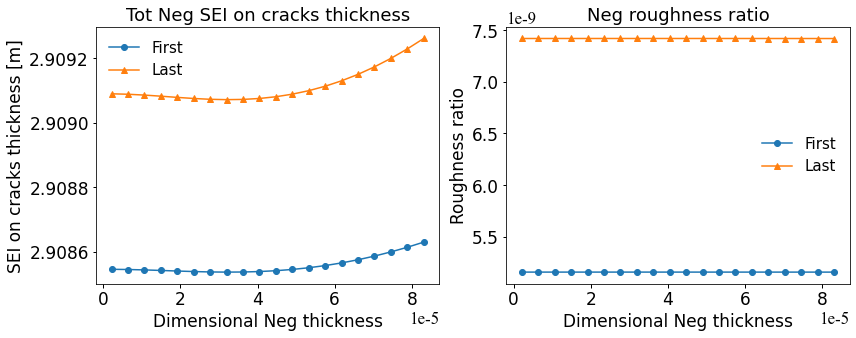

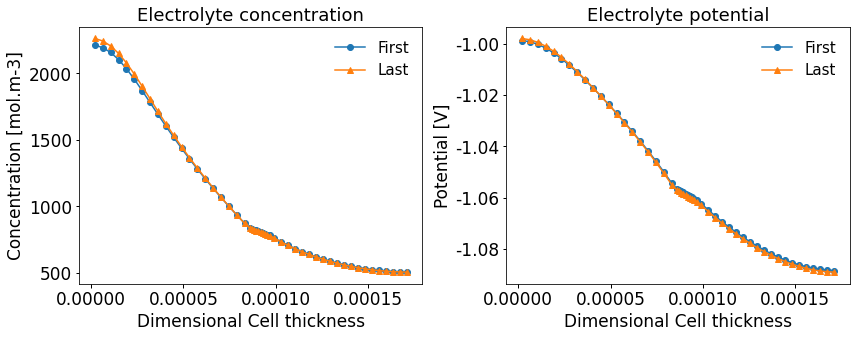

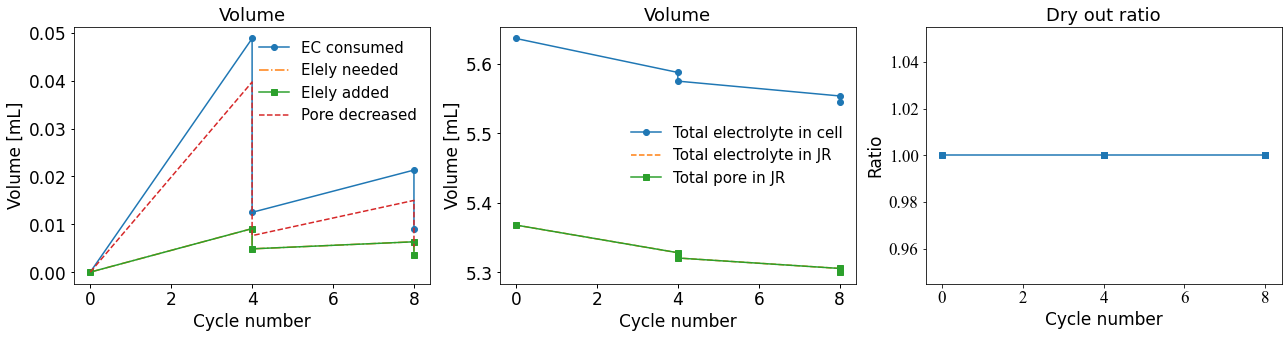

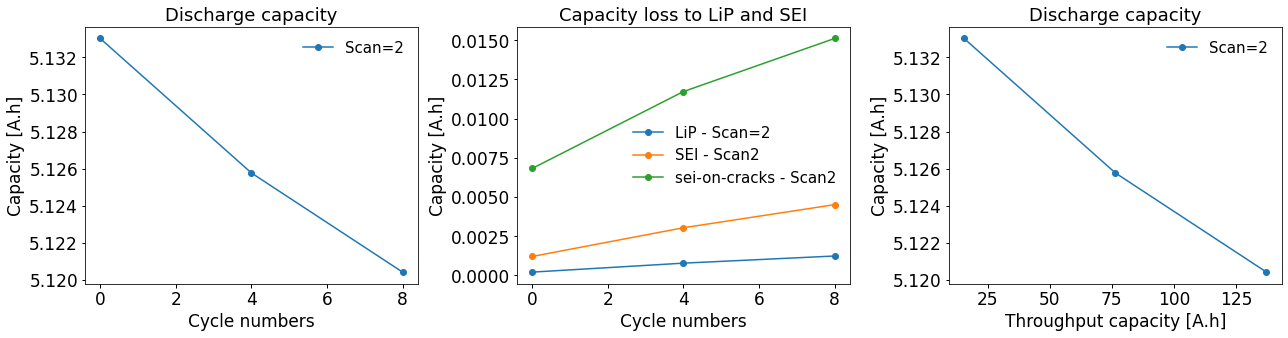

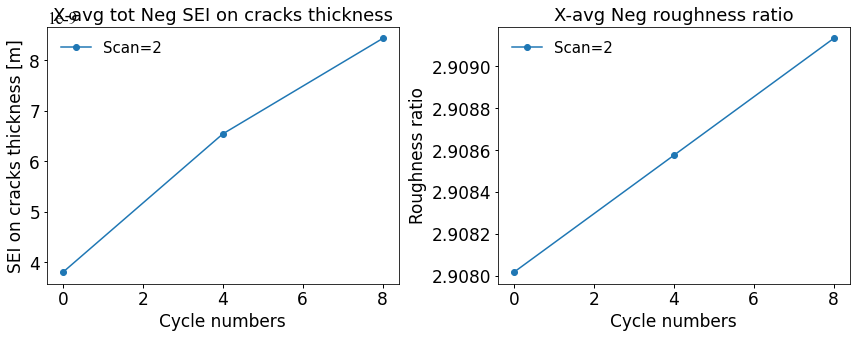

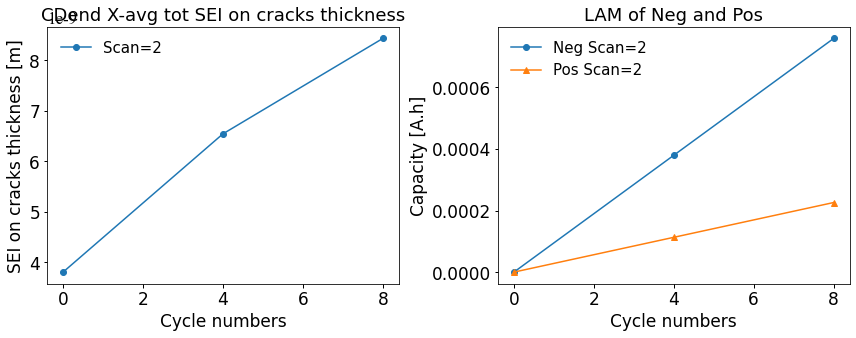

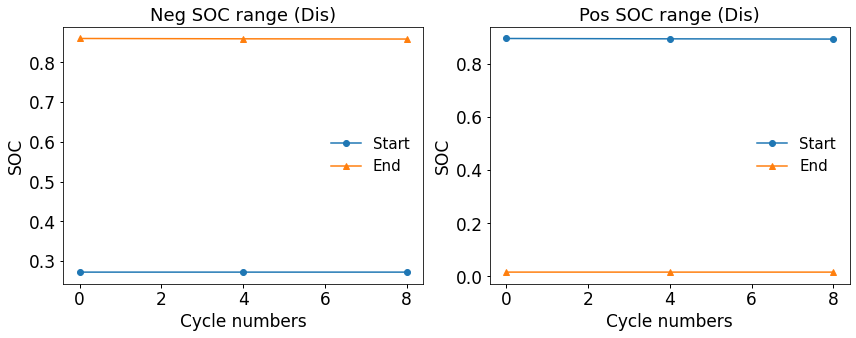

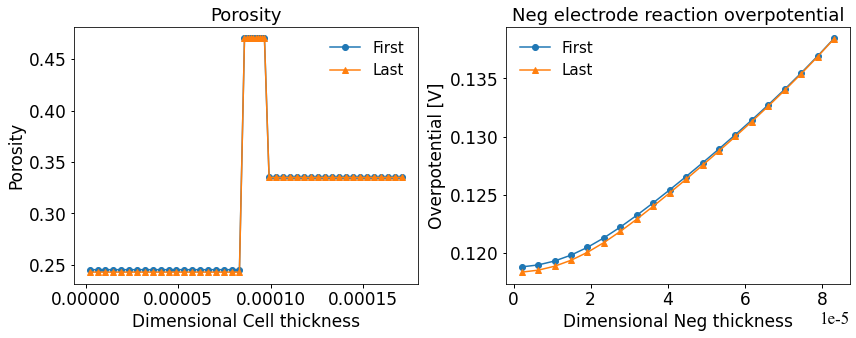

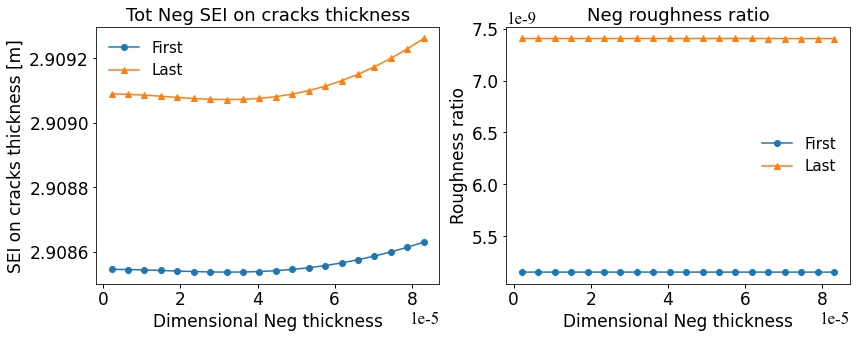

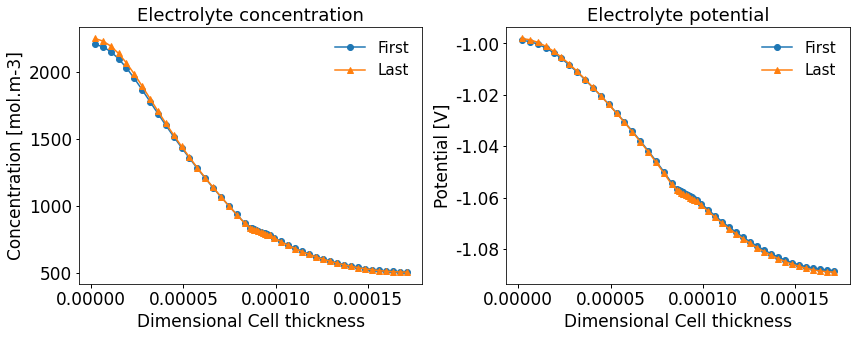

In [12]:
# Main code to run the model
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2R5/'; 
Target  = 'Test_P2R5_2/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'Solv_SEI_8cycles_1.xlsx';

sheet_name_xlsx = 'Results';

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];

# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.insert(1,"Dry out");
head_list.extend([ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"])
write_excel_xlsx(BasicPath + Target+book_name_xlsx, sheet_name_xlsx, [head_list])


# scan:
index_xlsx = 0; # DryOut option merge to Initial electrolyte excessive amount ratio: On and Off
for Para_dict_i in Para_dict_list:
   index_xlsx += 1;
   Run_model_wwo_dry_out(
      index_xlsx, Para_dict_i,   Path_pack , 
      keys_all,   exp_text_list, exp_index_pack )

